In [1]:
!pip install statsmodels
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 5.1 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488493 sha256=0aab4c1c18a9d43c81fb2ced7296dd55f546c67195a700832c0885d5ad4807ad
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [2]:
import warnings 
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.rcParams['font.size'] = 14
plt.rcParams['figure.dpi'] = 100
plt.rcParams['figure.figsize'] = (22,5)
import time
import numpy as np
import pandas as pd

In [3]:
import pyspark
from pyspark.sql import SparkSession, SQLContext
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.types import DoubleType
from pyspark.ml.regression import RandomForestRegressor
from pyspark.sql.functions import to_date
from pyspark.sql.functions import year, month, dayofmonth
from pyspark.ml.feature import MinMaxScaler

In [4]:
spark = SparkSession.builder.master("local[2]").appName("stock_prediction").getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/05/05 22:37:08 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [5]:
start = time.time()
sparkdf = spark.read.csv('/kaggle/input/stock-prices/stock_prices.csv', header =True)
end = time.time()
print('Time taken to load the spark dataframe', end - start)

Time taken to load the spark dataframe 5.512105226516724


In [6]:
start = time.time()
pandas_df = pd.read_csv('/kaggle/input/stock-prices/stock_prices.csv')
end = time.time()
print('Time taken to load the pandas dataframe', end - start)

Time taken to load the pandas dataframe 6.2854084968566895


In [7]:
spark

In [8]:
sparkdf.printSchema()

root
 |-- RowId: string (nullable = true)
 |-- Date: string (nullable = true)
 |-- SecuritiesCode: string (nullable = true)
 |-- Open: string (nullable = true)
 |-- High: string (nullable = true)
 |-- Low: string (nullable = true)
 |-- Close: string (nullable = true)
 |-- Volume: string (nullable = true)
 |-- AdjustmentFactor: string (nullable = true)
 |-- ExpectedDividend: string (nullable = true)
 |-- SupervisionFlag: string (nullable = true)
 |-- Target: string (nullable = true)



In [9]:
from pyspark.sql.functions import col, when

# Convert 'SupervisionFlag' from 'TRUE'/'FALSE' strings to boolean
sparkdf = sparkdf.withColumn('SupervisionFlag', when(col('SupervisionFlag') == "TRUE", True).otherwise(False))

# Converting the 'SupervisionFlag' from boolean to numeric
sparkdf = sparkdf.withColumn('SupervisionFlag', when(col('SupervisionFlag'), 1).otherwise(0))

#Converting all the columns to integer type
numeric_cols = ['SecuritiesCode','Open','High','Low','Close','Volume','AdjustmentFactor','ExpectedDividend','SupervisionFlag','Target']
for col in numeric_cols:
    sparkdf = sparkdf.withColumn(col, sparkdf[col].cast(DoubleType()))

In [10]:
sparkdf.printSchema()

root
 |-- RowId: string (nullable = true)
 |-- Date: string (nullable = true)
 |-- SecuritiesCode: double (nullable = true)
 |-- Open: double (nullable = true)
 |-- High: double (nullable = true)
 |-- Low: double (nullable = true)
 |-- Close: double (nullable = true)
 |-- Volume: double (nullable = true)
 |-- AdjustmentFactor: double (nullable = true)
 |-- ExpectedDividend: double (nullable = true)
 |-- SupervisionFlag: double (nullable = false)
 |-- Target: double (nullable = true)



In [11]:
#Checking for the null values
for i in sparkdf.columns:
    print(i,'with null values:',  sparkdf.filter(sparkdf[i].isNull()).count())

RowId with null values: 0


Date with null values: 0


SecuritiesCode with null values: 0


Open with null values: 7608


High with null values: 7608


Low with null values: 7608


Close with null values: 7608


Volume with null values: 0


AdjustmentFactor with null values: 0


ExpectedDividend with null values: 2313666
SupervisionFlag with null values: 0


Target with null values: 238


In [12]:
from pyspark.sql.functions import col

# Filter the DataFrame for rows where 'Open' is null
null_open_df = sparkdf.filter(col("Open").isNull())

# Show the top 5 rows with null values in the 'Open' column
null_open_df.show(5)

+-------------+----------+--------------+----+----+----+-----+------+----------------+----------------+---------------+-------------------+
|        RowId|      Date|SecuritiesCode|Open|High| Low|Close|Volume|AdjustmentFactor|ExpectedDividend|SupervisionFlag|             Target|
+-------------+----------+--------------+----+----+----+-----+------+----------------+----------------+---------------+-------------------+
|20170104_3540|2017-01-04|        3540.0|NULL|NULL|NULL| NULL|   0.0|             1.0|            NULL|            0.0|               NULL|
|20170104_9539|2017-01-04|        9539.0|NULL|NULL|NULL| NULL|   0.0|             1.0|            NULL|            0.0|-0.0041493775933609|
|20170105_3540|2017-01-05|        3540.0|NULL|NULL|NULL| NULL|   0.0|             1.0|            NULL|            0.0|               NULL|
|20170105_4621|2017-01-05|        4621.0|NULL|NULL|NULL| NULL|   0.0|             1.0|            NULL|            0.0|                0.0|
|20170106_3540|2017-

In [13]:
# dropping useless column
sparkdf = sparkdf.drop('ExpectedDividend')

In [14]:
sparkdf.printSchema()

root
 |-- RowId: string (nullable = true)
 |-- Date: string (nullable = true)
 |-- SecuritiesCode: double (nullable = true)
 |-- Open: double (nullable = true)
 |-- High: double (nullable = true)
 |-- Low: double (nullable = true)
 |-- Close: double (nullable = true)
 |-- Volume: double (nullable = true)
 |-- AdjustmentFactor: double (nullable = true)
 |-- SupervisionFlag: double (nullable = false)
 |-- Target: double (nullable = true)



In [15]:
from pyspark.sql import Window
from pyspark.sql.functions import last, col, year

# Assuming 'Date' is a column in your DataFrame formatted as a date
# Add a 'Year' column for partitioning
sparkdf = sparkdf.withColumn("Year", year("Date"))

# Define the window specification with partitioning by 'Year'
windowSpec = Window.partitionBy('Year').orderBy("Date").rowsBetween(Window.unboundedPreceding, 0)

# Apply the forward fill for each column in the list of columns to fill
columns_to_fill = ['Open', 'High', 'Low', 'Close', 'Target']
for column in columns_to_fill:
    sparkdf = sparkdf.withColumn(column, last(sparkdf[column], ignorenulls=True).over(windowSpec))

# Show the DataFrame to verify the results
sparkdf.show()

+-------------+----------+--------------+------+------+------+------+---------+----------------+---------------+-------------------+----+
|        RowId|      Date|SecuritiesCode|  Open|  High|   Low| Close|   Volume|AdjustmentFactor|SupervisionFlag|             Target|Year|
+-------------+----------+--------------+------+------+------+------+---------+----------------+---------------+-------------------+----+
|20180104_1301|2018-01-04|        1301.0|4270.0|4335.0|4220.0|4320.0|  61500.0|             1.0|            0.0|                0.0|2018|
|20180104_1332|2018-01-04|        1332.0| 595.0| 596.0| 587.0| 590.0|5027900.0|             1.0|            0.0| 0.0101694915254237|2018|
|20180104_1333|2018-01-04|        1333.0|3430.0|3435.0|3385.0|3415.0| 215000.0|             1.0|            0.0| -0.007320644216691|2018|
|20180104_1376|2018-01-04|        1376.0|1703.0|1740.0|1700.0|1725.0|   6800.0|             1.0|            0.0|-0.0090446579988694|2018|
|20180104_1377|2018-01-04|        

In [16]:
#Checking for the null values
for i in sparkdf.columns:
    print(i,'with null values:',  sparkdf.filter(sparkdf[i].isNull()).count())

RowId with null values: 0


Date with null values: 0


SecuritiesCode with null values: 0


Open with null values: 0


High with null values: 0


Low with null values: 0


Close with null values: 0


Volume with null values: 0


AdjustmentFactor with null values: 0
SupervisionFlag with null values: 0


Target with null values: 0


Year with null values: 0


In [17]:
from pyspark.sql.functions import col

# Filter the DataFrame for rows where 'Open' is null
null_open_df = sparkdf.filter(col("Open").isNull())

# Show the top 5 rows with null values in the 'Open' column
null_open_df.show(5)

+-----+----+--------------+----+----+---+-----+------+----------------+---------------+------+----+
|RowId|Date|SecuritiesCode|Open|High|Low|Close|Volume|AdjustmentFactor|SupervisionFlag|Target|Year|
+-----+----+--------------+----+----+---+-----+------+----------------+---------------+------+----+
+-----+----+--------------+----+----+---+-----+------+----------------+---------------+------+----+



In [18]:
sparkdf = sparkdf.withColumn('Date',to_date(sparkdf.Date, 'yyyy-MM-dd'))

In [19]:
sparkdf.printSchema()

root
 |-- RowId: string (nullable = true)
 |-- Date: date (nullable = true)
 |-- SecuritiesCode: double (nullable = true)
 |-- Open: double (nullable = true)
 |-- High: double (nullable = true)
 |-- Low: double (nullable = true)
 |-- Close: double (nullable = true)
 |-- Volume: double (nullable = true)
 |-- AdjustmentFactor: double (nullable = true)
 |-- SupervisionFlag: double (nullable = false)
 |-- Target: double (nullable = true)
 |-- Year: integer (nullable = true)



In [20]:
sparkdf.show(5)

+-------------+----------+--------------+------+------+------+------+---------+----------------+---------------+-------------------+----+
|        RowId|      Date|SecuritiesCode|  Open|  High|   Low| Close|   Volume|AdjustmentFactor|SupervisionFlag|             Target|Year|
+-------------+----------+--------------+------+------+------+------+---------+----------------+---------------+-------------------+----+
|20180104_1301|2018-01-04|        1301.0|4270.0|4335.0|4220.0|4320.0|  61500.0|             1.0|            0.0|                0.0|2018|
|20180104_1332|2018-01-04|        1332.0| 595.0| 596.0| 587.0| 590.0|5027900.0|             1.0|            0.0| 0.0101694915254237|2018|
|20180104_1333|2018-01-04|        1333.0|3430.0|3435.0|3385.0|3415.0| 215000.0|             1.0|            0.0| -0.007320644216691|2018|
|20180104_1376|2018-01-04|        1376.0|1703.0|1740.0|1700.0|1725.0|   6800.0|             1.0|            0.0|-0.0090446579988694|2018|
|20180104_1377|2018-01-04|        

In [21]:
sparkdf = sparkdf.withColumn('Day',dayofmonth(sparkdf.Date))
sparkdf = sparkdf.withColumn('Month',month(sparkdf.Date))
sparkdf = sparkdf.withColumn('Year',year(sparkdf.Date))

In [22]:
sparkdf.printSchema()

root
 |-- RowId: string (nullable = true)
 |-- Date: date (nullable = true)
 |-- SecuritiesCode: double (nullable = true)
 |-- Open: double (nullable = true)
 |-- High: double (nullable = true)
 |-- Low: double (nullable = true)
 |-- Close: double (nullable = true)
 |-- Volume: double (nullable = true)
 |-- AdjustmentFactor: double (nullable = true)
 |-- SupervisionFlag: double (nullable = false)
 |-- Target: double (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Day: integer (nullable = true)
 |-- Month: integer (nullable = true)



In [23]:
# export df to csv
sparkdf.coalesce(1).write.csv(path ='stock_prices_train_preprocessed', mode ='overwrite', header = True)

In [24]:
df1 = sparkdf.filter(col('RowId') == "20170104_3540")

In [25]:
df1.show()

+-------------+----------+--------------+------+------+------+------+------+----------------+---------------+------------------+----+---+-----+
|        RowId|      Date|SecuritiesCode|  Open|  High|   Low| Close|Volume|AdjustmentFactor|SupervisionFlag|            Target|Year|Day|Month|
+-------------+----------+--------------+------+------+------+------+------+----------------+---------------+------------------+----+---+-----+
|20170104_3540|2017-01-04|        3540.0|1579.0|1580.0|1562.0|1572.0|   0.0|             1.0|            0.0|0.0412698412698413|2017|  4|    1|
+-------------+----------+--------------+------+------+------+------+------+----------------+---------------+------------------+----+---+-----+



In [26]:
final_cols = ['Open', 'High', 'Low', 'Volume', 'AdjustmentFactor', 'Day', 'Month', 'Year', 'Close']
final_df = sparkdf.select(final_cols)

In [27]:
# vectorize data to get feature vector
assem = VectorAssembler(inputCols = final_cols[:-1], outputCol = 'features')  # Exclude 'Close' from inputCols
vectorized_data = assem.transform(final_df)

In [28]:
vectorized_data.show(5)

+------+------+------+---------+----------------+---+-----+----+------+--------------------+
|  Open|  High|   Low|   Volume|AdjustmentFactor|Day|Month|Year| Close|            features|
+------+------+------+---------+----------------+---+-----+----+------+--------------------+
|4270.0|4335.0|4220.0|  61500.0|             1.0|  4|    1|2018|4320.0|[4270.0,4335.0,42...|
| 595.0| 596.0| 587.0|5027900.0|             1.0|  4|    1|2018| 590.0|[595.0,596.0,587....|
|3430.0|3435.0|3385.0| 215000.0|             1.0|  4|    1|2018|3415.0|[3430.0,3435.0,33...|
|1703.0|1740.0|1700.0|   6800.0|             1.0|  4|    1|2018|1725.0|[1703.0,1740.0,17...|
|3910.0|3915.0|3880.0|  90700.0|             1.0|  4|    1|2018|3915.0|[3910.0,3915.0,38...|
+------+------+------+---------+----------------+---+-----+----+------+--------------------+
only showing top 5 rows



In [63]:
scaler = MinMaxScaler(inputCol='features', outputCol='features_norm')
scaled_model = scaler.fit(vectorized_data)
scaled_data = scaled_model.transform(vectorized_data)

show_data = scaled_data.select("features_norm")
show_data.show(5)

+--------------------+
|       features_norm|
+--------------------+
|[0.03871343327026...|
|[0.00528489302867...|
|[0.03107262407218...|
|[0.01536348420899...|
|[0.03543880075680...|
+--------------------+
only showing top 5 rows



In [30]:
from pyspark.sql.functions import col, when, to_date, dayofmonth, month, year, last

train_data = scaled_data.select('features_norm', 'Close')

# Load and process test data
test_df = spark.read.csv('/kaggle/input/stock-prices/stock_prices_test.csv', header = True)

# Convert 'SupervisionFlag' from 'TRUE'/'FALSE' strings to boolean
test_df = test_df.withColumn('SupervisionFlag', when(col('SupervisionFlag') == "TRUE", True).otherwise(False))

# Converting the 'SupervisionFlag' from boolean to numeric
test_df = test_df.withColumn('SupervisionFlag', when(col('SupervisionFlag'), 1).otherwise(0))

numeric_cols = ['SecuritiesCode','Open','High','Low','Close','Volume','AdjustmentFactor','SupervisionFlag','ExpectedDividend']

for col in numeric_cols:
    test_df = test_df.withColumn(col, test_df[col].cast(DoubleType()))

test_df = test_df.drop('ExpectedDividend')

test_df = test_df.withColumn('Date',to_date(test_df.Date, 'yyyy-MM-dd'))
    
test_df = test_df.withColumn('Day',dayofmonth(test_df.Date))
test_df = test_df.withColumn('Month',month(test_df.Date))
test_df = test_df.withColumn('Year',year(test_df.Date))

# Assuming 'Date' is a column in your DataFrame formatted as a date
# Add a 'Year' column for partitioning
test_df = test_df.withColumn("Year", year("Date"))

# Define the window specification with partitioning by 'Year'
windowSpec = Window.partitionBy('Year').orderBy("Date").rowsBetween(Window.unboundedPreceding, 0)

# Apply the forward fill for each column in the list of columns to fill
columns_to_fill = ['Open', 'High', 'Low', 'Close']
for column in columns_to_fill:
    test_df = test_df.withColumn(column, last(test_df[column], ignorenulls=True).over(windowSpec))

# export df to csv
test_df.coalesce(1).write.csv(path ='stock_prices_test_preprocessed', mode ='overwrite', header = True)

#Checking for the null values
for i in test_df.columns:
    print(i,'with null values:',  test_df.filter(test_df[i].isNull()).count())
    
test_vectorized = assem.transform(test_df)
test_scaled = scaled_model.transform(test_vectorized)
test_data = test_scaled.select('features_norm','Close')

RowId with null values: 0
Date with null values: 0
SecuritiesCode with null values: 0
Open with null values: 0
High with null values: 0
Low with null values: 0
Close with null values: 0
Volume with null values: 0
AdjustmentFactor with null values: 0
SupervisionFlag with null values: 0
Day with null values: 0
Month with null values: 0
Year with null values: 0


In [31]:
train_data.show(5)

+--------------------+------+
|       features_norm| Close|
+--------------------+------+
|[0.03871343327026...|4320.0|
|[0.00528489302867...| 590.0|
|[0.03107262407218...|3415.0|
|[0.01536348420899...|1725.0|
|[0.03543880075680...|3915.0|
+--------------------+------+
only showing top 5 rows



In [32]:
test_data.show(5)

+--------------------+------+
|       features_norm| Close|
+--------------------+------+
|[0.02699752583321...|2971.0|
|[0.00525760442439...| 589.0|
|[0.02141245815747...|2377.0|
|[0.01106098093436...|1224.0|
|[0.01205246688982...|1351.0|
+--------------------+------+
only showing top 5 rows



In [66]:
# fit model
from pyspark.ml.regression import LinearRegression

lr = LinearRegression(featuresCol='features_norm', labelCol='Close', maxIter=10, regParam=0.3, elasticNetParam=0.8)
lr_model = lr.fit(train_data)

In [67]:
from pyspark.ml.evaluation import RegressionEvaluator

predictions = lr_model.transform(test_data)
evaluator = RegressionEvaluator(labelCol = "Close", predictionCol = "prediction", metricName = "rmse")
rmse = evaluator.evaluate(predictions)
print(predictions.show(5))
print("Root Mean Squared Error (RMSE) on test data: {:.3f}".format(rmse))

+--------------------+------+------------------+
|       features_norm| Close|        prediction|
+--------------------+------+------------------+
|[0.02699752583321...|2971.0|2976.0397391226006|
|[0.00525760442439...| 589.0| 592.8704424457703|
|[0.02141245815747...|2377.0| 2371.856195249271|
|[0.01106098093436...|1224.0|1230.8525033844912|
|[0.01205246688982...|1351.0| 1349.978072796049|
+--------------------+------+------------------+
only showing top 5 rows

None
Root Mean Squared Error (RMSE) on test data: 70.418


In [68]:
from pyspark.sql.functions import monotonically_increasing_id

#export Predicted_Close to csv
outputdf = spark.read.csv('/kaggle/input/stock-prices/stock_prices_test.csv', header =True)
outputdf = outputdf.withColumn("row_id", monotonically_increasing_id())
predictions_df = predictions.withColumn("row_id", monotonically_increasing_id())

# Join the DataFrames on the new row index
joined_df = outputdf.join(predictions_df.select("row_id", "prediction"), on="row_id", how="inner")

# Drop the 'row_id' as it's no longer needed
joined_df = joined_df.drop("row_id")

print(joined_df.show(5))

joined_df.write.csv('/kaggle/working/regression_prediction', mode="overwrite", header=True)

+-------------+----------+--------------+------+------+------+------+-------+----------------+----------------+---------------+------------------+
|        RowId|      Date|SecuritiesCode|  Open|  High|   Low| Close| Volume|AdjustmentFactor|ExpectedDividend|SupervisionFlag|        prediction|
+-------------+----------+--------------+------+------+------+------+-------+----------------+----------------+---------------+------------------+
|20211206_1301|2021-12-06|          1301|2982.0|2982.0|2965.0|2971.0|   8900|             1.0|            NULL|          False|2976.0397391226006|
|20211206_1332|2021-12-06|          1332| 592.0| 599.0| 588.0| 589.0|1360800|             1.0|            NULL|          False| 592.8704424457703|
|20211206_1333|2021-12-06|          1333|2368.0|2388.0|2360.0|2377.0| 125900|             1.0|            NULL|          False| 2371.856195249271|
|20211206_1375|2021-12-06|          1375|1230.0|1239.0|1224.0|1224.0|  81100|             1.0|            NULL|       

In [35]:
import pandas as pd

# Convert Spark DataFrame to Pandas DataFrame if needed
cols=['SecuritiesCode','Date','Open','High','Low','Close','Volume','AdjustmentFactor','Target','Day','Month','Year']
df = sparkdf.select(cols).toPandas()  # cols should include 'Date' and other necessary columns
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

In [36]:
# Create a full date range from min to max
full_range = pd.date_range(start=df.index.min(), end=df.index.max(), freq='D')

In [37]:
# Find missing dates by comparing the full range to the actual index
missing_dates = full_range.difference(df.index)

In [38]:
print("Missing dates:")
print(missing_dates)

Missing dates:
DatetimeIndex(['2017-01-07', '2017-01-08', '2017-01-09', '2017-01-14',
               '2017-01-15', '2017-01-21', '2017-01-22', '2017-01-28',
               '2017-01-29', '2017-02-04',
               ...
               '2021-11-03', '2021-11-06', '2021-11-07', '2021-11-13',
               '2021-11-14', '2021-11-20', '2021-11-21', '2021-11-23',
               '2021-11-27', '2021-11-28'],
              dtype='datetime64[ns]', length=593, freq=None)


You will need to decide how to handle the duplicates. If you want to aggregate the data (e.g., taking the average or the last entry for each day), you can use the groupby method with an aggregation function

In [39]:
df = df.groupby(['Date', 'SecuritiesCode']).last().reset_index()
df['Date'] = pd.to_datetime(df['Date'])

In [40]:
# Unique securities
securities = df['SecuritiesCode'].unique()

# List to hold each processed DataFrame
processed_dfs = []

for security in securities:
    # Filter df for the current security
    temp_df = df[df['SecuritiesCode'] == security]
    temp_df.set_index('Date', inplace=True)
    
    # Create a date range for this security
    idx = pd.date_range(start=temp_df.index.min(), end=temp_df.index.max(), freq='D')
    
    # Reindex with forward fill
    temp_df = temp_df.reindex(idx, method='ffill')
    
    # Store the processed DataFrame
    temp_df['SecuritiesCode'] = security  # Add the security code back as a column
    processed_dfs.append(temp_df)

# Concatenate all the processed DataFrames
final_df = pd.concat(processed_dfs)

In [41]:
final_df.reset_index(inplace=True)
final_df.rename(columns={'index': 'Date'}, inplace=True)

In [42]:
# # Get unique securities
# securities = final_df['SecuritiesCode'].unique()

# # Dictionaries to store decomposition components for each security
# trends = {}
# seasonals = {}
# residuals = {}

# for security in securities:
#     # Filter the DataFrame for the current security
#     sec_data = final_df[final_df['SecuritiesCode'] == security]
    
#     # Check if data is sufficient for decomposition
#     if len(sec_data) > 365:  # Ensure there's at least one year of data
#         result = seasonal_decompose(sec_data['Close'], model='additive', period=365)
        
#         # Store results
#         trends[security] = result.trend
#         seasonals[security] = result.seasonal
#         residuals[security] = result.resid
#     else:
#         print(f"Not enough data for security {security}")

In [43]:
# import matplotlib.pyplot as plt

# # Assuming trends, seasonals, and residuals are dictionaries with security codes as keys and pandas Series as values
# # Setup the figure and axes
# fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(14, 18), sharex=True)

# # Plot Trends for all securities
# for security, data in trends.items():
#     axes[0].plot(data.dropna(), label=f'Security {security}')
# axes[0].set_title('Trends for All Securities')
# axes[0].set_ylabel('Trend')
# axes[0].legend(loc='upper left')

# # Plot Seasonality for all securities
# for security, data in seasonals.items():
#     axes[1].plot(data.dropna(), label=f'Security {security}')
# axes[1].set_title('Seasonality for All Securities')
# axes[1].set_ylabel('Seasonality')
# axes[1].legend(loc='upper left')

# # Plot Residuals for all securities
# for security, data in residuals.items():
#     axes[2].plot(data.dropna(), label=f'Security {security}')
# axes[2].set_title('Residuals for All Securities')
# axes[2].set_xlabel('Date')
# axes[2].set_ylabel('Residual')
# axes[2].legend(loc='upper left')

# # Adjust layout
# plt.tight_layout()
# plt.show()

lstm

In [44]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class LSTM(nn.Module):
    def __init__(self, input_size=8, sequence_num=31, lstm_dim=128,
                 num_layers=2, output_size=1):
        super().__init__()
        
        self.lstm = nn.LSTM(input_size, lstm_dim, num_layers, batch_first=True, bidirectional=True)
        self.linear1 = nn.Linear(lstm_dim*sequence_num*2, 1)
        self.bn1 = nn.BatchNorm1d(lstm_dim*sequence_num*2)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)  # Output shape: [batch_size, sequence_num, lstm_dim * 2]
        x = lstm_out.reshape(lstm_out.shape[0], -1)
        x = self.bn1(x)
        x = self.linear1(x)
        return x

In [45]:
from pyspark.sql.functions import lit

dataset_dict = {}
sparkdf = sparkdf.drop('Year', 'Day', 'Month')
sparkdf = sparkdf.withColumn('ExpectedDividend', lit(0))
stock_price_df = sparkdf.toPandas()
print(stock_price_df)

for sc in stock_price_df['SecuritiesCode'].unique():
    dataset_dict[str(sc)] = stock_price_df[stock_price_df['SecuritiesCode'] == sc].values[:, 3:].astype(np.float32)
print(dataset_dict['1301.0'])

                 RowId        Date  SecuritiesCode    Open    High     Low  \
0        20180104_1301  2018-01-04          1301.0  4270.0  4335.0  4220.0   
1        20180104_1332  2018-01-04          1332.0   595.0   596.0   587.0   
2        20180104_1333  2018-01-04          1333.0  3430.0  3435.0  3385.0   
3        20180104_1376  2018-01-04          1376.0  1703.0  1740.0  1700.0   
4        20180104_1377  2018-01-04          1377.0  3910.0  3915.0  3880.0   
...                ...         ...             ...     ...     ...     ...   
2332526  20211203_9990  2021-12-03          9990.0   514.0   528.0   513.0   
2332527  20211203_9991  2021-12-03          9991.0   782.0   794.0   782.0   
2332528  20211203_9993  2021-12-03          9993.0  1690.0  1690.0  1645.0   
2332529  20211203_9994  2021-12-03          9994.0  2388.0  2396.0  2380.0   
2332530  20211203_9997  2021-12-03          9997.0   690.0   711.0   686.0   

          Close     Volume  AdjustmentFactor  SupervisionFlag  

In [46]:
from torch.utils.data.sampler import SubsetRandomSampler

class MyDataset(torch.utils.data.Dataset):
    def __init__(self, X, sequence_num=31, y=None, mode='train'):
        self.data = X
        self.teacher = y
        self.sequence_num = sequence_num
        self.mode = mode
    def __len__(self):
        return len(self.teacher)

    def __getitem__(self, idx):
        out_data = self.data[idx]
        if self.mode == 'train':
            out_label =  self.teacher[idx[-1]]
            return out_data, out_label
        else:
            return out_data
        
def create_dataloader(dataset, dataset_num, sequence_num=31, input_size=8, batch_size=32, shuffle=False):
    sampler = np.array([list(range(i, i+sequence_num)) for i in range(dataset_num-sequence_num+1)])
    if shuffle == True:
        np.random.shuffle(sampler)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size, num_workers=4, sampler=sampler)
    return dataloader
#### Check operation ####
X_check, y_check = dataset_dict['1301.0'][:, :-1], dataset_dict['1301.0'][:, -1]
dataset_check = MyDataset(X_check, y=y_check, sequence_num=31, mode='train')
dataloader_check = create_dataloader(dataset_check, X_check.shape[0], sequence_num=31, input_size=8, batch_size=32, shuffle=False)
for b, tup in enumerate(dataloader_check):
    print('---------')
    print(tup[0].shape, tup[1].shape)
    break

---------
torch.Size([32, 31, 8]) torch.Size([32])


In [59]:
from tqdm import tqdm
epochs = 3
batch_size = 512
# Check whether GPU is available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# Model Instantiation
model = LSTM(input_size=8, sequence_num=31, lstm_dim=128, num_layers=2, output_size=1)
model.to(device)
model.train()
# setting optimizer
lr = 0.0001
weight_decay = 1.0e-05
optimizer = torch.optim.Adagrad(model.parameters(), lr=lr, weight_decay=weight_decay)
# setting criterion
criterion = nn.MSELoss()
# set iteration counter
iteration = 0
# 
log_train = [[0], [np.inf]]
for epoch in range(epochs):
    epoch_loss = 0.0
    for sc in tqdm(stock_price_df['SecuritiesCode'].unique()):
        X, y = dataset_dict[str(sc)][:, :-1], dataset_dict[str(sc)][:, -1]
        dataset = MyDataset(X, y=y, sequence_num=31, mode='train')
        dataloader = create_dataloader(dataset, X.shape[0], sequence_num=31, input_size=8, batch_size=batch_size, shuffle=True)
        for data, targets in dataloader:
            data, targets = data.to(device), targets.to(device)
            
            optimizer.zero_grad()
            
            data = data.to(torch.float32)
            output = model.forward(data)
            targets = targets.to(torch.float32)
            
            loss = criterion(output.view(1,-1)[0], targets)
            
            loss.backward()
            
            optimizer.step()
            
            epoch_loss += loss.item()
            
            iteration += 1
    epoch_loss /= iteration
    print('epoch_loss={}'.format(epoch_loss))
    log_train[0].append(iteration)
    log_train[1].append(epoch_loss)

 76%|███████▌  | 1513/2000 [08:23<02:45,  2.94it/s]Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ccda2d783a0><function _MultiProcessingDataLoaderIter.__del__ at 0x7ccda2d783a0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers

    if w.is_alive():
  File "/opt/conda/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
AssertionError: can only test a child process
    self._shutdown_workers()Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/multiprocessing/queues.py"

epoch_loss=0.017246881597844158


100%|██████████| 2000/2000 [10:55<00:00,  3.05it/s]


epoch_loss=0.00412831544164021


100%|██████████| 2000/2000 [10:54<00:00,  3.06it/s]

epoch_loss=0.002177678436849785


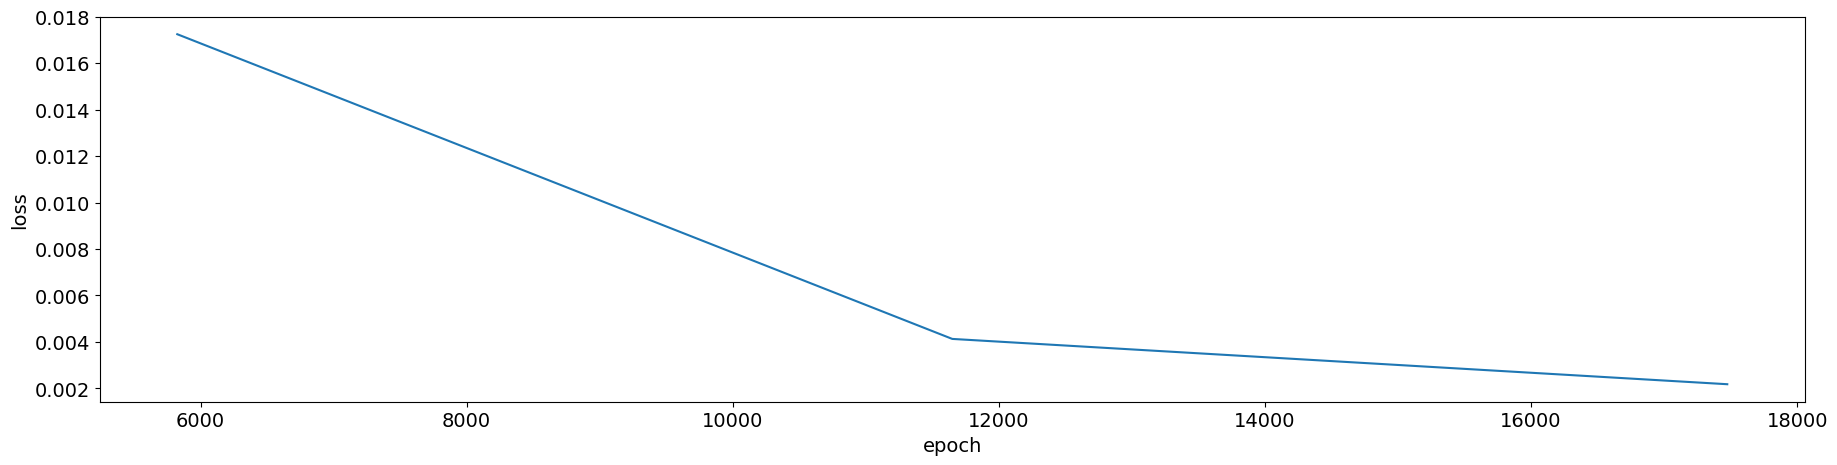

In [60]:
import matplotlib.pyplot as plt
plt.plot(log_train[0][1:], log_train[1][1:])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [61]:
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from pyspark.sql.functions import date_format


sequence_length = 31

def predict(model, X_df, sequence=sequence_length):
    pred_df = X_df[['Date', 'SecuritiesCode']]  # This will not be used for predictions
    # Define the columns that should be used for the model input
    model_columns = ['Open', 'High', 'Low', 'Close', 'Volume', 'AdjustmentFactor', 'ExpectedDividend', 'SupervisionFlag']

    code_group = X_df.groupby('SecuritiesCode')
    sequence_list = []

    for sc, group in code_group:
        # Ensure to select only the columns relevant for the model
        X = group[model_columns].values  # Only numerical columns should be used here
        sequence_list.append(X)
    
    print(sequence_list)

    # Stack all the collected sequences for model input
    X_all = np.stack(sequence_list)
    y_pred = []

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    model.eval()

    with torch.no_grad():
        for it in range(0, X_all.shape[0], 512):
            data = X_all[it:it+512]
            data_tensor = torch.from_numpy(data.astype(np.float32)).to(device)
            output = model(data_tensor)
            output_np = output.cpu().numpy().flatten()
            y_pred.extend(output_np)

    pred_df['Close_Predicted'] = y_pred[:len(pred_df)]
    pred_df['Rank'] = pred_df['Close_Predicted'].rank(ascending=False, method="first") - 1
    pred_df['Rank'] = pred_df['Rank'].astype(int)

    return pred_df

test_df = test_df.drop('Year', 'Day', 'Month')
test_df = test_df.withColumn('ExpectedDividend', lit(0))
# Select columns in the specific order you want
column_order = [
    col for col in test_df.columns if col not in ['ExpectedDividend', 'SupervisionFlag']
] + ['ExpectedDividend', 'SupervisionFlag']  # Add 'ExpectedDividend' before 'SupervisionFlag'

# Reorder DataFrame according to the new column order
test_df = test_df.select(column_order)

test_df = test_df.withColumn("Date", date_format("Date", "yyyy-MM-dd"))

test_df_pandas = test_df.toPandas()

stdsc = StandardScaler()
columns = ['Open', 'High', 'Low', 'Close', 'Volume', 'AdjustmentFactor', 'ExpectedDividend', 'SupervisionFlag']
test_df_pandas[columns] = stdsc.fit_transform(test_df_pandas[columns])
test_X_df = test_df_pandas

y_pred = predict(model, test_X_df)
print(y_pred.shape)
print(y_pred)

[array([[ 0.0485873 ,  0.03855049,  0.05363936,  0.04273011, -0.27756731,
         0.01581337,  0.        ,  0.        ],
       [ 0.05224973,  0.05728141,  0.05944561,  0.0641412 , -0.27271675,
         0.01581337,  0.        ,  0.        ]]), array([[-0.4984882 , -0.49922989, -0.49841834, -0.49983588,  0.36532221,
         0.01581337,  0.        ,  0.        ],
       [-0.50375294, -0.5060001 , -0.51072758, -0.50735254,  2.78508626,
         0.01581337,  0.        ,  0.        ]]), array([[-0.09195845, -0.09549967, -0.08687175, -0.09256972, -0.22192853,
         0.01581337,  0.        ,  0.        ],
       [-0.08875383, -0.08895514, -0.084317  , -0.08528084, -0.22126276,
         0.01581337,  0.        ,  0.        ]]), array([[-0.35244879, -0.35479873, -0.35070749, -0.35519717, -0.24323295,
         0.01581337,  0.        ,  0.        ],
       [-0.3531355 , -0.34870554, -0.35001074, -0.34608607, -0.22064455,
         0.01581337,  0.        ,  0.        ]]), array([[-0.32749849, -0

RuntimeError: running_mean should contain 512 elements not 7936